# Implementation of an ARMA model

In [25]:
from scipy.stats.distributions import norm
from scipy.optimize import fmin
from scipy.optimize import minimize
from scipy import linalg as la
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from pydataset import data as pydata
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
from statsmodels.tsa.base.datetools import dates_from_str
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX

In [26]:
import warnings
warnings.filterwarnings('ignore')

- Implement a naive ARMA model to forecast the weater in Provo, UT for the next $n$ days

In [27]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(1,1) on data. Let error terms be drawn from
    a standard normal and let all constants be 1.
    Predict n values and plot original data with predictions.
    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    # Initialize
    data = np.load(file)
    z = list(np.diff(data))
    phi = 0.5
    theta = 0.1
    eps = [np.random.normal(0,1) for _ in range(q)]
    N = len(z) - 1
    
    # ARMA algorithm
    for t in range(n):
        ep = np.random.normal(0,1)
        arma = eps[t]
        eps.append(ep)        
        
        for i in range(p):
            arma += phi * z[N+t-i]
            
        for i in range(q):
            arma += theta * eps[t-i]
            
        z.append(arma)    
    
    # Plot the differences with predicted data
    plt.plot(np.linspace(0,N+1,N+1), z[:N+1])
    plt.plot(np.linspace(N+2,len(z),n-1),z[N+2:])
    plt.legend(['Actual Data', 'Forecast Data'])
    plt.xlabel('Days')
    plt.ylabel('Temperature Change ($\mu = 0$)')
    plt.title('ARMA Naive Forecast')
    plt.show()

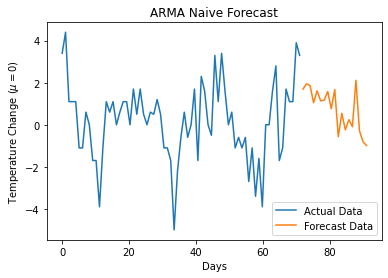

In [28]:
arma_forecast_naive()

### Implement an ARMA model from scratch

- Turn the ARMA model into a state space model and find the log-likelihood

In [29]:
def arma_likelihood(file='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space. 
    Return the log-likelihood of the ARMA model.
    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error
    Return:
        log_likelihood (float)
    """
    # Initialize
    data = np.load(file)
    z = np.diff(data)
    n = len(z)
    
    # Get the parameters from given methods below
    F,Q,H = state_space_rep(phis, thetas, mu, std)[:3]
    mus, covs = kalman(F,Q,H,z - mu)
    draws = []
    
    # Compute all of the draws from the normal
    for i in range(n):  
        draw = norm.pdf(x=z[i], loc=H@mus[i] + mu, scale=np.sqrt(H@covs[i]@H.T))
        draws.append(draw)
    
    # Return log of the product of all draws
    return np.sum(np.log(draws))

In [30]:
def model_identification(file='weather.npy',p=1,q=1):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model
    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model
    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    def f(x):
        return -1*arma_likelihood(file, phis=x[:p], thetas=x[p:p+q], mu=x[-2], std=x[-1])
    
    # Initialize
    time_series = np.load(file)
    
    # Find parameters
    x0 = np.zeros(p+q+2)
    x0[-2] = time_series.mean()
    x0[-1] = time_series.std()
    sol = minimize(f,x0,method="SLSQP")
    sol = sol['x']
    
    phi = sol[:p]
    theta = sol[p:p+q]
    mu = sol[-2]
    std = sol[-1]
    return (np.array(phi), np.array(theta), mu, std)

- Apply the new ARMA model to the data in `weather.npy`

In [31]:
def arma_forecast(file='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0., std=0., n=30):
    """
    Forecast future observations of data.
    
    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    Returns:
        new_mus (ndarray (n,)): future means
        new_covs (ndarray (n,)): future standard deviations
    """
    data = np.load(file)
    z = np.diff(data)
    n = len(z)
    N = len(z) - 1
    F,Q,H = state_space_rep(phis, thetas, mu, std)[:3]
    mus, covs = kalman(F,Q,H,z-mu)
    
    X0 = mus[-1]
    P0 = covs[-1]
    
    # Perform the update once
    y = z[-1] - H@X0
    S = H@P0@H.T
    K = P0@H.T@la.inv(S)
    X0 = X0 + K@y
    P0 = (np.eye(len(K@H)) - K@H) @ P0
    
    new_mus = [F@X0]
    new_covs = [F@P0@F.T + Q]
    
    for i in range(1,n):
        new_mus.append(F@new_mus[i-1])
        new_covs.append(F@new_covs[i-1]@F.T + Q)
        
    obs = []
    for i in range(len(new_mus)):
        obs.append(H@new_mus[i] + mu)
        
    # Plot the differences with predicted data
    std = np.einsum("so,noO,SO->nsS",H,covs,H).ravel()[-1]
    plt.plot(np.linspace(0,N+1,N+1), z[:N+1], label='Old Data')
    plt.plot(np.linspace(N+2,N+len(obs)+1,len(obs)),obs, '--', label='Forecast')
    plt.plot(np.linspace(N+2,N+len(obs)+1,len(obs)),obs + std, '--', c='green', label='$95%$ CI')
    plt.plot(np.linspace(N+2,N+len(obs)+1,len(obs)),obs - std, '--', c='green', label='$95%$ CI')
    plt.legend(['Old Data', 'Forecast', '$95\%$ Confidence Interval'])
    plt.title('ARMA Forecast')
    plt.xlabel('Days')
    plt.ylabel('Change in Temperature $(C) - \mu = 0$')
    plt.show()
        
    return (np.array(new_mus), np.array(covs))
        

### Implement an ARMA model using the statsmodels package

- Build a model with statsmodels that results in a minimal AIC
- Apply that model to the data in `weather.npy`

In [35]:
def sm_arma(file ='weather.npy', p=4, q=4, n=30):
    """
    Build an ARMA model with statsmodel and 
    predict future n values.
    Parameters:
        file (str): data file
        p (int): maximum order of autoregressive model
        q (int): maximum order of moving average model
        n (int): number of values to predict
    Return:
        aic (float): aic of optimal model
    """
    data = np.load(file)
    z = np.diff(data)
    N = len(z) - 1
    
    best_aic = np.inf
    
    # Find best model that minimizes AIC
    for i in range(1,p+1):
        for j in range(1,q+1):
            model = ARIMA(z, order=(i,0,j), trend='c').fit(method='innovations_mle')
            
            if model.aic < best_aic:
                best_aic = model.aic
                best_model = model
    
    new_vals = best_model.predict(start=0, end=len(data)+n)
    
    # Plot
    plt.plot(np.linspace(0,N+1,N+1), z[:N+1], label='Old Data')
    plt.plot(np.linspace(0,len(new_vals),len(new_vals)), new_vals, label='ARIMA Model')
    plt.title('Statsmodel ARIMA Forecast')
    plt.xlabel('Days')
    plt.ylabel('Change in Temperature C ($\mu = 0$)')
    plt.legend()
    plt.show()
    
    return best_aic


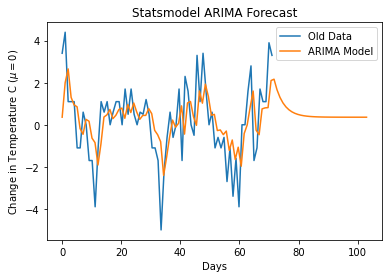

272.73413326170083

In [36]:
sm_arma(p=1,q=1)

- Use the statsmodels VARMAX class to forecast macroeconomic data from start to end date.
- Plot the original data, forecast data, and a $95\%$ confidence interval around the forecast.

In [37]:
def sm_varma(start = '1959-09-30', end = '2012-09-30'):
    """
    Build an ARMA model with statsmodel and
    predict future n values.
​
    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting
​
    Return:
        aic (float): aic of optimal model
    """
    # Load in data
    df = sm.datasets.macrodata.load_pandas().data
    # Create DateTimeIndex
    dates = df[['year', 'quarter']].astype(int).astype(str)
    dates = dates["year"] + "Q" + dates["quarter"]
    dates = dates_from_str(dates)
    df.index = pd.DatetimeIndex(dates)
    # Select columns used in prediction
    df = df[['realgdp','realcons','realinv']]
    
    model = VARMAX(df[['realgdp', 'realcons', 'realinv']])
    model = model.fit(maxiter=1000, disp=False, ic='aic')
    predict = model.predict(start, end)
    
    # Get CI
    forecast_obj = model.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha=0.05)
    
    # Plot
    fig, ax = plt.subplots(3,1, figsize=(10,9))
    # Plot realgdp
    ax[0].plot(df['realgdp'])
    ax[0].plot(predict['realgdp'])
    ax[0].plot(all_CI['upper realgdp'], '--', c='green')
    ax[0].plot(all_CI['lower realgdp'], '--', c='green')
    ax[0].legend(['realgdp', 'Forecast', '$95\%$ Confidence Interval'])

    # Plot realcons
    ax[1].plot(df['realcons'])
    ax[1].plot(predict['realcons'])
    ax[1].plot(all_CI['upper realcons'], '--', c='green')
    ax[1].plot(all_CI['lower realcons'], '--', c='green')
    ax[1].legend(['realcons', 'Forecast', '$95\%$ Confidence Interval'])
    
    # Plot realinv
    ax[2].plot(df['realinv'])
    ax[2].plot(predict['realinv'])
    ax[2].plot(all_CI['upper realinv'], '--', c='green')
    ax[2].plot(all_CI['lower realinv'], '--', c='green')
    ax[2].legend(['realinv', 'Forecast', '$95\%$ Confidence Interval'])
    
    
    plt.show()
    
    return model.aic

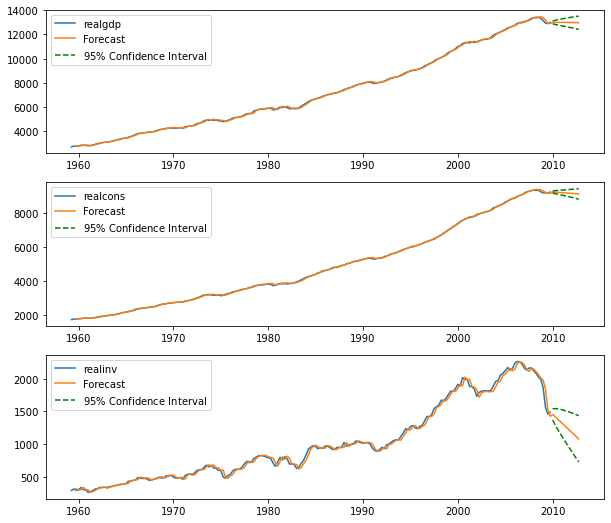

5973.16073913938

In [38]:
sm_varma()

### Helper functions

In [20]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F),np.eye(dim_states**2)).dot(Q.flatten()).reshape(
            (dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        t1 = np.linalg.solve(H.dot(covs[i-1]).dot(H.T),np.eye(H.shape[0]))
        t2 = covs[i-1].dot(H.T.dot(t1.dot(H.dot(covs[i-1]))))
        covs[i] = F.dot((covs[i-1] - t2).dot(F.T)) + Q
        mus[i] = F.dot(mus[i-1]) + F.dot(covs[i-1].dot(H.T.dot(t1))).dot(
                time_series[i-1] - H.dot(mus[i-1]))
    return mus, covs

In [21]:
def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series
    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0][:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas
    return F, Q, H, dim_states, dim_time_series